In [9]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

from sklearn.metrics import confusion_matrix, classification_report

In [17]:
data_type1 = "train"
data_type2 = "test"
# month = "07"
# category = "잔액정보"

# local
root_path = '../data/open'

# colab
# root_path = '/content/drive/MyDrive/12조 파이널프로젝트/data'

drive_folder1 = f'{root_path}/{data_type1}/5.잔액정보/'
drive_folder2 = f'{root_path}/{data_type2}/5.잔액정보/'

In [2]:
# # 학습이 완료된 모델을 저장할 파일 이름
# best_model_path = 'model/best_model_balance.dat'
# # 교차검증 횟수
# cv_count = 10
# # 교차 검증
# kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)
# # 평가 결과를 담을 리스트
# f1_score_list = []
# # 학습 모델 이름
# model_name_list = []

In [21]:
# 데이터를 읽어온다.
train_df = pd.read_parquet(f'{drive_folder1}train_잔액정보_통합_전처리1.parquet')
test_df = pd.read_parquet(f'{drive_folder2}test_잔액정보_통합_전처리1.parquet')

In [4]:
drop_cols = ['ID', '기준년월']

train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

In [5]:
# 3. 타겟과 피처 분리
X = train_df.drop(columns=['Segment'])
y = train_df['Segment']

In [6]:
# 타겟을 숫자로 변환 (문자 클래스 → 정수 인코딩)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
# 4. 학습/검증용 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y, random_state=42
)

In [8]:
# 🔽 시간 측정 시작
start = time.time()

In [9]:
# 5. 모델 정의 및 학습
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',       # 빠른 학습
    device='cuda',            # GPU 사용 (CUDA 가능할 경우)
    random_state=42,
    verbose=1
)
model.fit(X_train, y_train)
print(f"⏱️ 학습 시간: {time.time() - start:.2f}초")

⏱️ 학습 시간: 156.87초


In [10]:
# 8. 예측 및 평가
y_pred = model.predict(X_valid)
print("📊 Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print("\n📋 Classification Report:")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

📊 Confusion Matrix:
[[    35      0    158      1      0]
 [     0      4     24      1      0]
 [     9      0  10192   8409   6908]
 [     1      0   4092  25191  40564]
 [     0      0   1498  12718 370195]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.18      0.29       194
           B       1.00      0.14      0.24        29
           C       0.64      0.40      0.49     25518
           D       0.54      0.36      0.43     69848
           E       0.89      0.96      0.92    384411

    accuracy                           0.85    480000
   macro avg       0.77      0.41      0.48    480000
weighted avg       0.82      0.85      0.83    480000



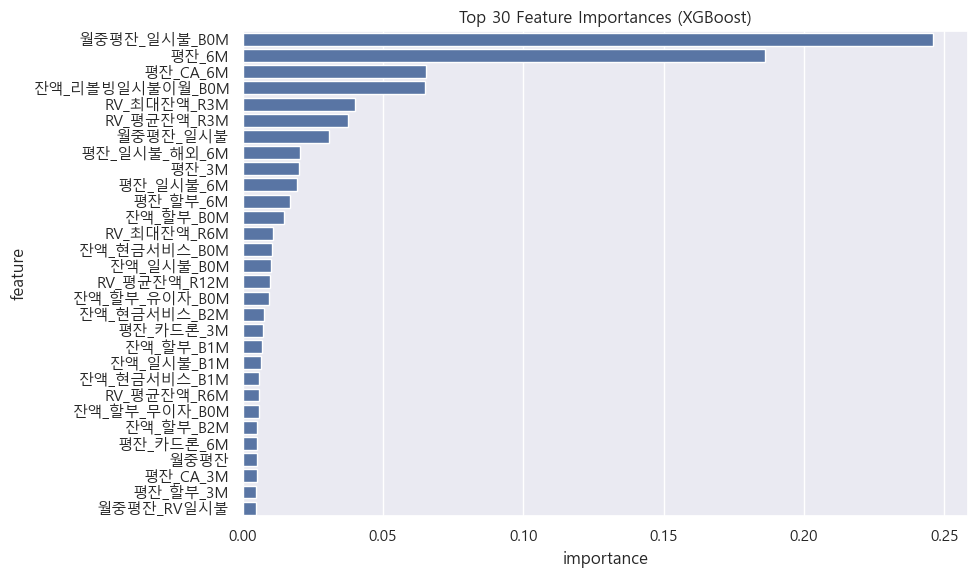

In [11]:
# 10. 피처 중요도 시각화
importances = model.feature_importances_
feat_names = X.columns
importance_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(30))
plt.title('Top 30 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [34]:
# 상위 30개 피처
# importance_df.head(30)

In [50]:
# 하위 30개 피처
# importance_df.tail(30)

In [28]:
# 중요도 기준 설정
threshold = 0.001

# 제거 대상 피처 목록
low_importance_feats = importance_df[importance_df['importance'] < threshold]['feature'].tolist()
print(f"제거할 피처 수: {len(low_importance_feats)}")

# 피처 제거
X_selected = X.drop(columns=low_importance_feats)

# 다시 학습/검증 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


제거할 피처 수: 5


In [30]:
# 5. 모델 정의 및 학습
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',       # 빠른 학습
    device='cuda',            # GPU 사용 (CUDA 가능할 경우)
    random_state=42,
    verbose=1
)
model.fit(X_train, y_train)
print(f"⏱️ 학습 시간: {time.time() - start:.2f}초")

⏱️ 학습 시간: 342.66초


In [32]:
# 8. 예측 및 평가
y_pred = model.predict(X_valid)
print("📊 Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print("\n📋 Classification Report:")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

📊 Confusion Matrix:
[[    37      0    156      1      0]
 [     1      2     25      1      0]
 [    11      0  10140   8472   6895]
 [     2      0   4079  25245  40522]
 [     0      1   1489  12752 370169]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       0.73      0.19      0.30       194
           B       0.67      0.07      0.12        29
           C       0.64      0.40      0.49     25518
           D       0.54      0.36      0.43     69848
           E       0.89      0.96      0.92    384411

    accuracy                           0.84    480000
   macro avg       0.69      0.40      0.45    480000
weighted avg       0.82      0.84      0.83    480000



In [38]:
for feat in low_importance_feats:
    temp_X = X.drop(columns=[feat])
    X_train, X_valid, y_train, y_valid = train_test_split(temp_X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
    
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist', device='cuda')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='macro')
    
    print(f"📉 Removed: {feat} → macro F1: {f1:.4f}")


📉 Removed: 평잔_CA_해외_3M → macro F1: 0.4548
📉 Removed: 연체잔액_RV일시불_B0M → macro F1: 0.4767
📉 Removed: 연체잔액_대환론_B0M → macro F1: 0.4767
📉 Removed: 매각잔액_B1M → macro F1: 0.4767
📉 Removed: 연체정보_유무 → macro F1: 0.4767


In [54]:
# 중요도 기준 설정
threshold = 0.0001

# 제거 대상 피처 목록
low_importance_feats = importance_df[importance_df['importance'] < threshold]['feature'].tolist()
print(f"제거할 피처 수: {len(low_importance_feats)}")

# 피처 제거
X_selected = X.drop(columns=low_importance_feats)

# 다시 학습/검증 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(low_importance_feats)

제거할 피처 수: 4
['연체잔액_RV일시불_B0M', '연체잔액_대환론_B0M', '매각잔액_B1M', '연체정보_유무']


In [46]:
# 5. 모델 정의 및 학습
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',       # 빠른 학습
    device='cuda',            # GPU 사용 (CUDA 가능할 경우)
    random_state=42,
    verbose=1
)
model.fit(X_train, y_train)
print(f"⏱️ 학습 시간: {time.time() - start:.2f}초")

⏱️ 학습 시간: 8233.81초


In [48]:
# 8. 예측 및 평가
y_pred = model.predict(X_valid)
print("📊 Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print("\n📋 Classification Report:")
print(classification_report(y_valid, y_pred, target_names=le.classes_))

📊 Confusion Matrix:
[[    35      0    158      1      0]
 [     0      4     24      1      0]
 [     9      0  10192   8409   6908]
 [     1      0   4092  25191  40564]
 [     0      0   1498  12718 370195]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.18      0.29       194
           B       1.00      0.14      0.24        29
           C       0.64      0.40      0.49     25518
           D       0.54      0.36      0.43     69848
           E       0.89      0.96      0.92    384411

    accuracy                           0.85    480000
   macro avg       0.77      0.41      0.48    480000
weighted avg       0.82      0.85      0.83    480000



In [56]:
train_df['Segment'].value_counts()

Segment
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64